## Making decisions with pandas


### quantile analysis: random data 

Quintile analysis is a common framework for evaluating the efficacy of security factors

#### What is a factor ?

A factor is a method for scoring/ranking sets of securities. For a particular point in time and for a
particular set of securities, a factor can be represented as a pandas series where the index is an
array of the security identifiers and the values are the scores or ranks.


### Quitiles/Buckets

If we take factor scores over time, we can, at each point in time, split the set of securities into 5
equal buckets, or quintiles, based on the order of the factor scores. There is nothing particularly
sacred about the number 5. 
We could have used 3 or 10. But we use 5 often. Finally, we track the
performance of each of the five buckets to determine if there is a meaningful difference in the
returns. We tend to focus more intently on the difference in returns of the bucket with the highest
rank relative to that of the lowest rank.


#### generating time series data for explanation

Returns:- generate random returns for specified number of securities and periods.

Signals: generate random signals for specified number of securities and periods and with
prescribed level of correlation with Returns. In order for a factor to be useful, there must be
some information or correlation between the scores/ranks and subsequent returns. If there
weren't correlation, we would see it. That would be a good exercise for the reader, duplicate
this analysis with random data generated with 0 correlation.

In [2]:
import pandas as pd
import numpy as np

num_securities = 1000
num_periods = 1000
period_frequency = 'W'

start_date = "2000-12-31"

np.random.seed([3,1415])

means = [0,0]
covariance = [[1.,5e-3],
             [5e-3,1.]]

#generating a set of data [0] and m[1] with ~0.005 correlation
m = np.random.multivariate_normal(means, covariance,
 (num_periods, num_securities)).T

In [4]:
# generating index
ids = pd.Index(['s{:05d}'.format(s) for s in range(num_securities)])
tidx = pd.date_range(start=start_date, periods=num_periods, freq=period_frequency)


I divide m[0] by 25 to scale down to something that looks like stock returns. I also add 1e-7 to give a
modest positive mean return.

In [5]:
security_returns = pd.DataFrame(m[0] / 25 + 1e-7, tidx, ids)
security_signals = pd.DataFrame(m[1], tidx, ids)


# pd.qcut - Create Quintile Buckets

In [7]:
def qcut(s, q=5):
 labels = ['q{}'.format(i) for i in range(1, 6)]
 return pd.qcut(s, q, labels=labels)

cut = security_signals.stack().groupby(level=0).apply(qcut)

In [8]:
#Use these cuts as an index on our returns
returns_cut = security_returns.stack().rename('returns') \
 .to_frame().set_index(cut, append=True) \
 .swaplevel(2, 1).sort_index().squeeze() \
 .groupby(level=[0, 1]).mean().unstack()

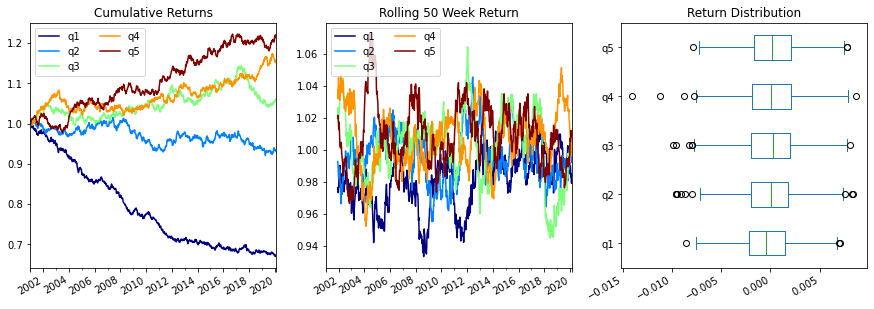

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

# Cumulative Returns
returns_cut.add(1).cumprod() \
 .plot(colormap='jet', ax=ax1, title="Cumulative Returns")
leg1 = ax1.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg1.get_frame().set_alpha(.8)

# Rolling 50 Week Return
returns_cut.add(1).rolling(50).apply(lambda x: x.prod()) \
 .plot(colormap='jet', ax=ax2, title="Rolling 50 Week Return")
leg2 = ax2.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg2.get_frame().set_alpha(.8)
# Return Distribution

returns_cut.plot.box(vert=False, ax=ax3, title="Return Distribution")

fig.autofmt_xdate()

plt.show()

### Visualize Quintile Correlation with scatter_matrix

In [15]:
def max_dd(returns):
 """returns is a series"""
 r = returns.add(1).cumprod()
 dd = r.div(r.cummax()).sub(1)
 mdd = dd.min()
 end = dd.argmin()
 start = r.loc[:end].argmax()
 return mdd, start, end

def max_dd_df(returns):
 """returns is a dataframe"""
 series = lambda x: pd.Series(x, ['Draw Down', 'Start', 'End'])
 return returns.apply(max_dd).apply(series)

In [18]:
#max_dd_df(returns_cut)


In [19]:
draw_downs = max_dd_df(returns_cut)

fig, axes = plt.subplots(5, 1, figsize=(10, 8))

for i, ax in enumerate(axes[::-1]):
 returns_cut.iloc[:, i].add(1).cumprod().plot(ax=ax)
 sd, ed = draw_downs[['Start', 'End']].iloc[i]
 ax.axvspan(sd, ed, alpha=0.1, color='r')
 ax.set_ylabel(returns_cut.columns[i])
    
fig.suptitle('Maximum Draw Down', fontsize=18)
fig.tight_layout()
plt.subplots_adjust(top=.95)


TypeError: cannot do slice indexing on DatetimeIndex with these indexers [998] of type int64